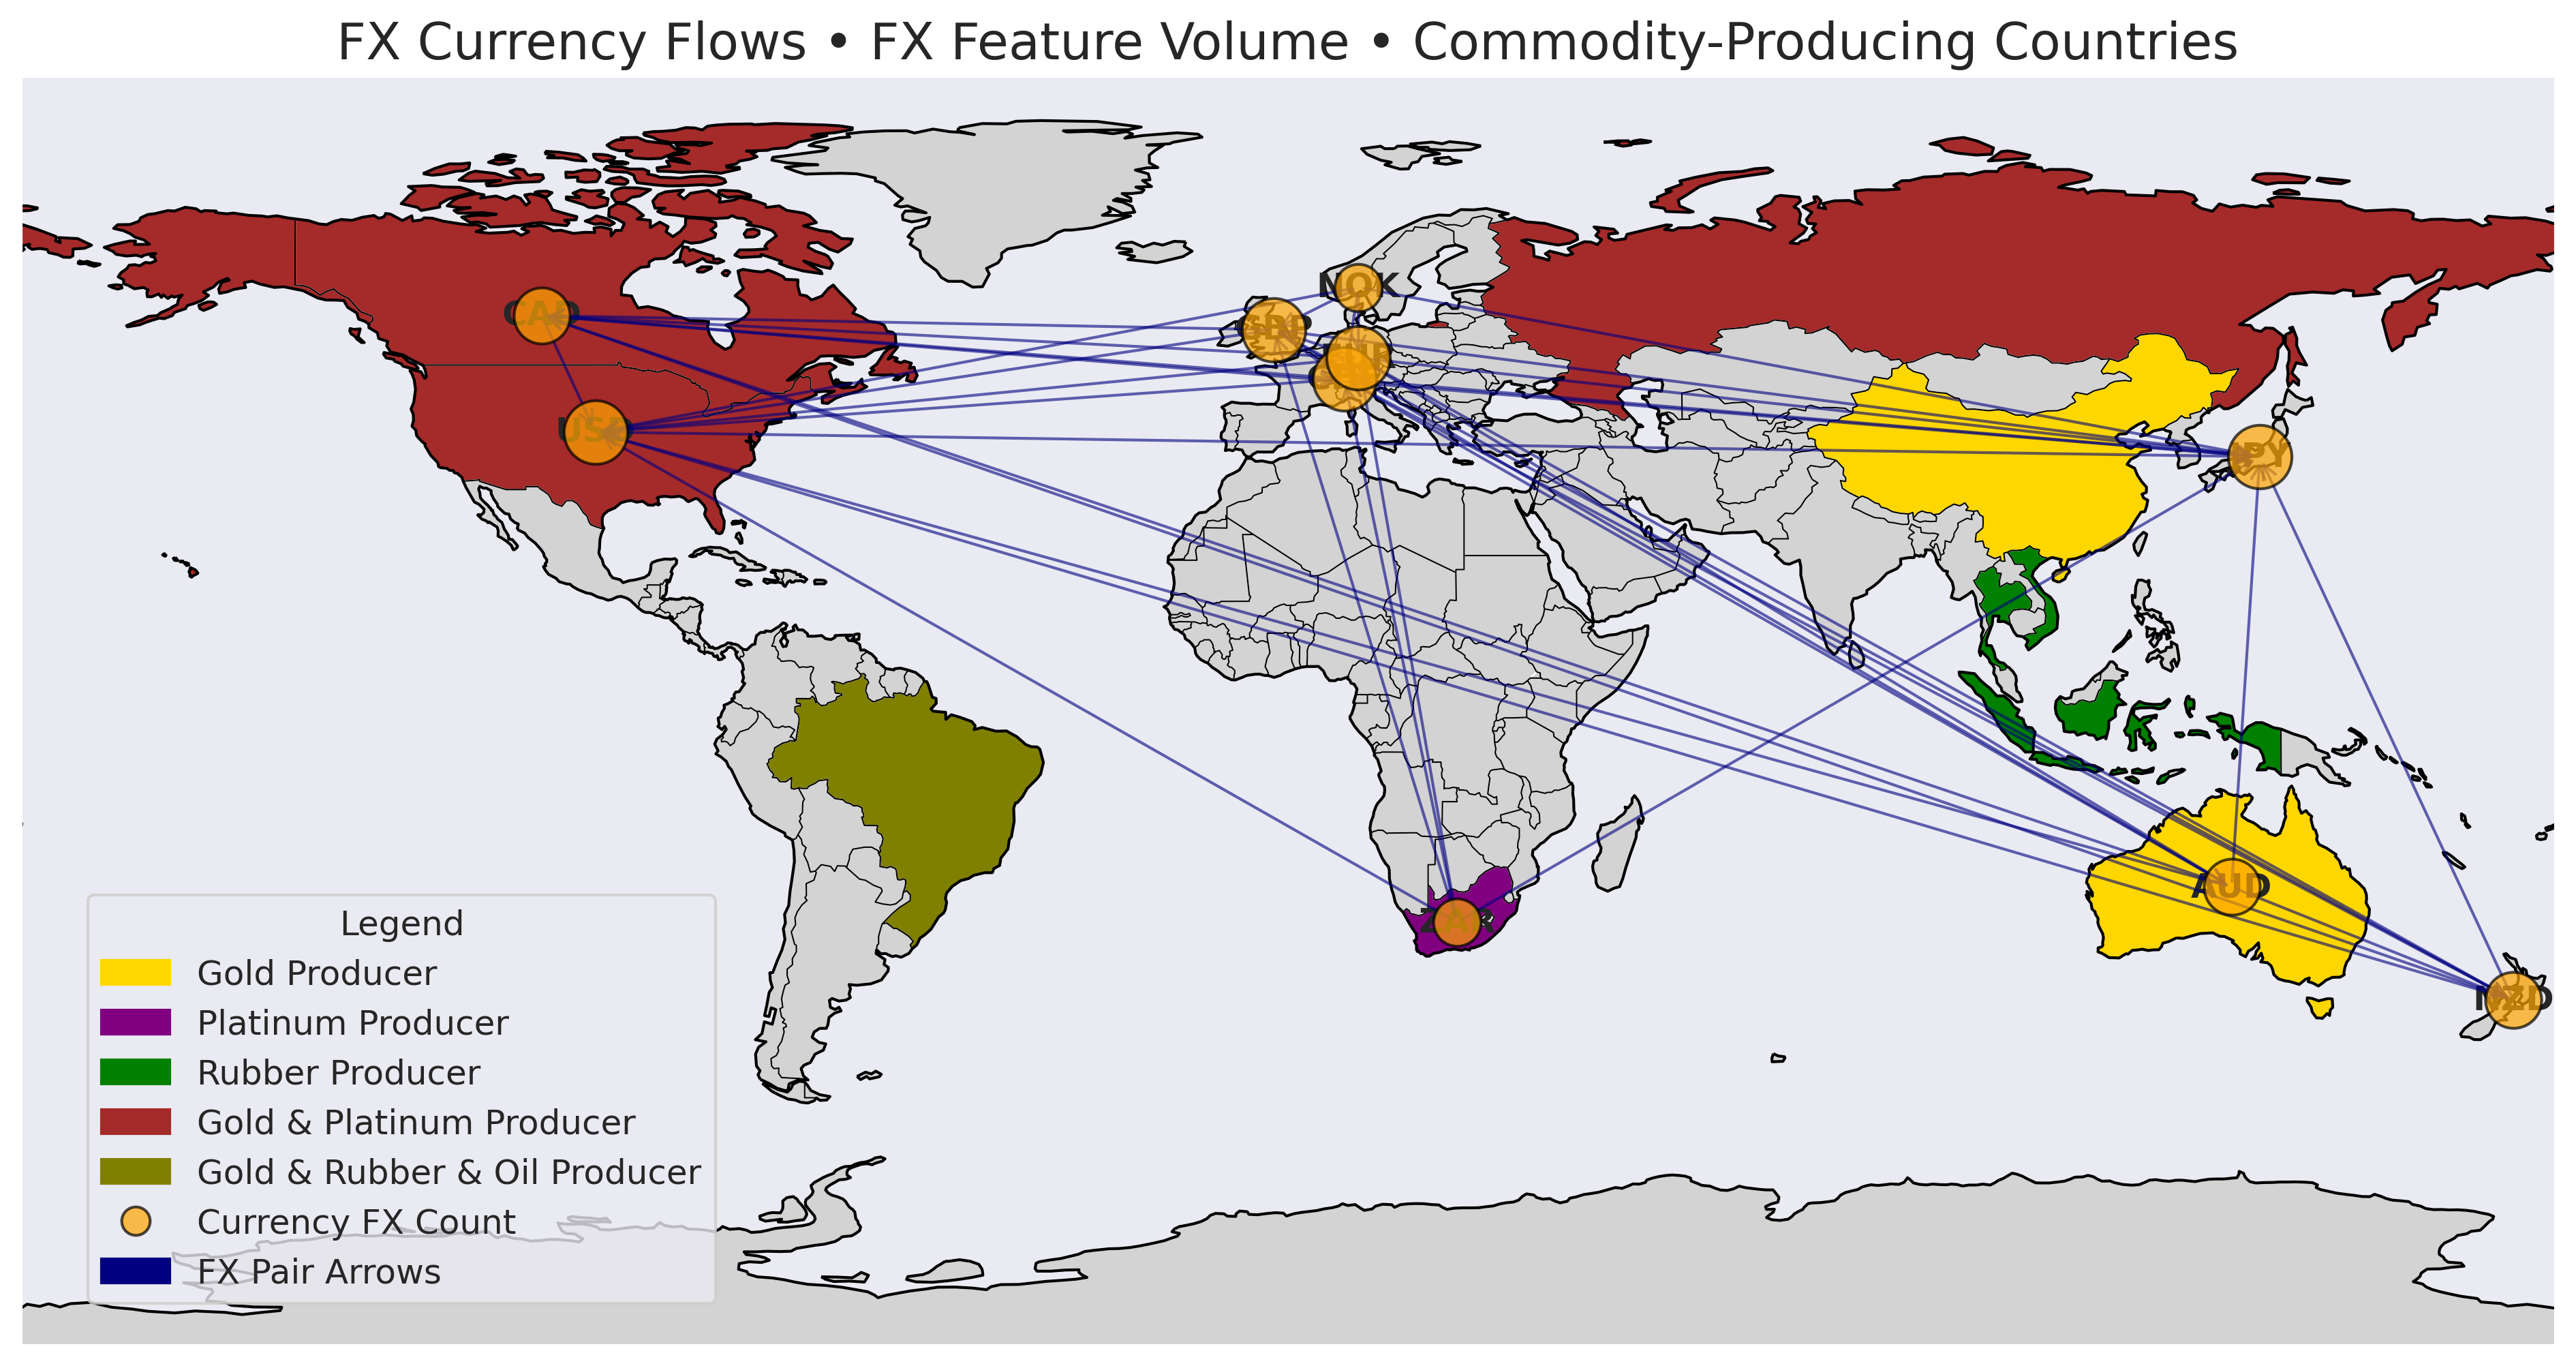

In [1]:
# Display previously saved image in notebook
from IPython.display import Image, display
display(Image(filename="/kaggle/input/mitsui-public-henao/commodity_fx_map.png"))

## 🧾 Notebook Overview & Embedded Map Output

I have a problem and I need to understand what data I'm working with. I started looking at the time series and I realized that I needed to know how everything connects geographically. This notebook serves as an initial Geo-economic, finance-oriented **Exploratory Data Analysis (EDA)** for the Mitsui Commodity Prediction Challenge. It covers key structural features such as LME metals time series, US equity/ETF proxies (GLD, OXY, SPY), FX pair flows, and commodity-producing country mappings.

Our approach emphasizes:

- **Discovery through visualization**: histograms, correlation heatmaps, bubble and line plots.
- **Domain relevance**: extracting ticker metadata via `yfinance`, mapping commodity geography (gold, platinum, lead, rubber, oil).
- **Structural understanding**: charting feature distributions, FX exposure, and country-level commodity correlations.

At the conclusion of these analytical cells, we generate:

- A high‑resolution **PNG map** visualizing:
  - FX pair arrows
  - Bubble sizes representing FX feature volume
  - Country shading by commodity production 

Below the map output is shown inline for immediate inspection. This is not a thorough study and you're welcome to fork this notebook and use add to it. A geographical understanding should help us understand this competition better.


In [2]:
# ===================================================================================
#   Mitsui Commodity Challenge – Graphical-first EDA Helper
# ===================================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List
import warnings

# Set style and color palette
sns.set_theme(style="darkgrid")
COLOR_PALETTE = sns.color_palette("viridis", n_colors=10)

# ========================
# 1. Graphical-first EDAHelper
# ========================
class EDAHelper:
    """
    EDAHelper: emphasizes visual summarization of time-series financial data.
    Features:
      - Time-series overview of price & volume
      - Distribution plots with violin + box
      - Heatmap of missingness
      - Rolling statistics over time
    """
    def __init__(self, df: pd.DataFrame, labels: Optional[pd.DataFrame]=None, name: str="dataset"):
        self.df = df
        self.labels = labels
        self.name = name

    def time_series_summary(self, features: List[str], date_col="date_id", figsize=(16,6)):
        """
        Plots line charts of feature trends over time (subsampled for clarity).
        """
        df_ts = self.df[[date_col] + features].copy()
        df_ts = df_ts.sort_values(date_col)
        plt.figure(figsize=figsize)
        for feat in features:
            plt.plot(df_ts[date_col], df_ts[feat], label=feat, alpha=0.8)
        plt.title(f"{self.name}: Feature Time Series", fontsize=16)
        plt.xlabel("Date ID"); plt.ylabel("Value")
        plt.legend(loc='upper right', ncol=2)
        plt.show()

    def distribution_violin(self, columns: Optional[List[str]] = None, n=8):
        """
        Displays violin + box plots for top-n numeric columns.
        """
        if columns is None:
            columns = self.df.select_dtypes(include=np.number).columns[:n].tolist()
        df_melt = self.df[columns].melt(var_name="feature", value_name="value")
        plt.figure(figsize=(12,6))
        sns.violinplot(x="feature", y="value", data=df_melt, palette="viridis", scale="width", inner="quartile")
        plt.xticks(rotation=45, ha="right")
        plt.title(f"{self.name}: Violin + Box Distributions", fontsize=16)
        plt.tight_layout()
        plt.show()

    def rolling_stats(self, feature: str, window: int=50, date_col="date_id"):
        """
        Plots rolling mean and volatility for a given feature over time.
        """
        df = self.df.sort_values(date_col).set_index(date_col)
        roll = df[feature].astype(np.float64).rolling(window=window)
        plt.figure(figsize=(14,6))
        plt.plot(df.index, roll.mean(), label=f"{feature} rolling mean", color=COLOR_PALETTE[0])
        plt.fill_between(df.index, roll.mean() - roll.std(), roll.mean() + roll.std(),
                         color=COLOR_PALETTE[1], alpha=0.3, label="±1 rolling std")
        plt.title(f"{self.name}: Rolling Mean & Volatility – {feature}", fontsize=16)
        plt.xlabel("Date ID")
        plt.legend()
        plt.show()

    def missingness_heatmap(self):
        """
        Heatmap of NaNs across all feature columns.
        """
        plt.figure(figsize=(18,3))
        sns.heatmap(self.df.isnull().astype(float), cbar=False, cmap="viridis", yticklabels=False)
        plt.title(f"{self.name}: Missingness Heatmap", fontsize=16)
        plt.xlabel("Features")
        plt.show()


# Memory saving
First of all some data organizing that I'll be using in my submission. I leave it here if you want to get started too. This saves memory and time without sacrificing too much precision

In [3]:
# ===================================================================================
# ✅ Complete Data Loading Cell for Mitsui Commodity Prediction Challenge
# ===================================================================================
import os
import pandas as pd
import numpy as np
import warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

# Utility to list files for debugging
print("Available files under /kaggle/input/mitsui-commodity-prediction-challenge:")
print(os.listdir("/kaggle/input/mitsui-commodity-prediction-challenge"))

# Define paths
BASE = "/kaggle/input/mitsui-commodity-prediction-challenge"
TRAIN_CSV = f"{BASE}/train.csv"
TEST_CSV = f"{BASE}/test.csv"
LABELS_CSV = f"{BASE}/train_labels.csv"
PAIRS_CSV = f"{BASE}/target_pairs.csv"
LAGGED_DIR = f"{BASE}/lagged_test_labels"

# ================================================================================
# Memory optimization (NaN-safe)
def reduce_mem_usage(df: pd.DataFrame, verbose: bool = True) -> pd.DataFrame:
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        if df[col].isnull().all(): continue
        col_type = df[col].dtype
        c_min, c_max = df[col].min(skipna=True), df[col].max(skipna=True)
        if col_type != object and col_type.name != 'category':
            if str(col_type).startswith('int'):
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if not np.isnan(c_min) and not np.isnan(c_max):
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f"Memory downcast: {start_mem:.2f} → {end_mem:.2f} MB ({100*(start_mem-end_mem)/start_mem:.1f}% reduction)")
    return df

# ================================================================================
# Loading
train = reduce_mem_usage(pd.read_csv(TRAIN_CSV), verbose=True)
test = reduce_mem_usage(pd.read_csv(TEST_CSV), verbose=True)
labels = reduce_mem_usage(pd.read_csv(LABELS_CSV), verbose=True)
pairs = reduce_mem_usage(pd.read_csv(PAIRS_CSV), verbose=True)

# Load all lagged test labels
lagged = {}
for fname in sorted(os.listdir(LAGGED_DIR)):
    if fname.endswith(".csv"):
        lag = fname.replace("test_labels_lag_", "").replace(".csv", "")
        path = os.path.join(LAGGED_DIR, fname)
        lagged[f"lag_{lag}"] = reduce_mem_usage(pd.read_csv(path), verbose=True)

print("Loaded lagged test label files:", list(lagged.keys()))

# ================================================================================
# Confirm variables are defined
print(f"train: {train.shape}, labels: {labels.shape}, pairs: {pairs.shape}")

# Instantiate graphical-first EDAHelper (previously defined)
helper = EDAHelper(train, labels, name="Train Set")
#helper.missingness_heatmap()


Available files under /kaggle/input/mitsui-commodity-prediction-challenge:
['lagged_test_labels', 'target_pairs.csv', 'train_labels.csv', 'train.csv', 'test.csv', 'kaggle_evaluation']
Memory downcast: 8.35 → 2.46 MB (70.6% reduction)
Memory downcast: 0.57 → 0.17 MB (70.0% reduction)
Memory downcast: 6.36 → 1.59 MB (75.0% reduction)
Memory downcast: 0.01 → 0.03 MB (-224.8% reduction)
Memory downcast: 0.11 → 0.03 MB (74.9% reduction)
Memory downcast: 0.11 → 0.03 MB (74.9% reduction)
Memory downcast: 0.11 → 0.03 MB (74.9% reduction)
Memory downcast: 0.11 → 0.03 MB (74.9% reduction)
Loaded lagged test label files: ['lag_1', 'lag_2', 'lag_3', 'lag_4']
train: (1961, 558), labels: (1961, 425), pairs: (424, 3)


# Takeaway:
The memory optimization is very effective—each file is now small enough for quick experimentation, even with almost 2000 columns combined.

# GEOGRAPHY OF THE DATA:

This is a competition with truly global data. But How much data is coming and where is it coming from?

Distinct prefixes: ['FX', 'JPX', 'LME', 'US', 'date']
Number of distinct prefixes: 5
Counter({'US': 475, 'JPX': 40, 'FX': 38, 'LME': 4, 'date': 1})


/tmp/ipykernel_13/1246733843.py:25: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


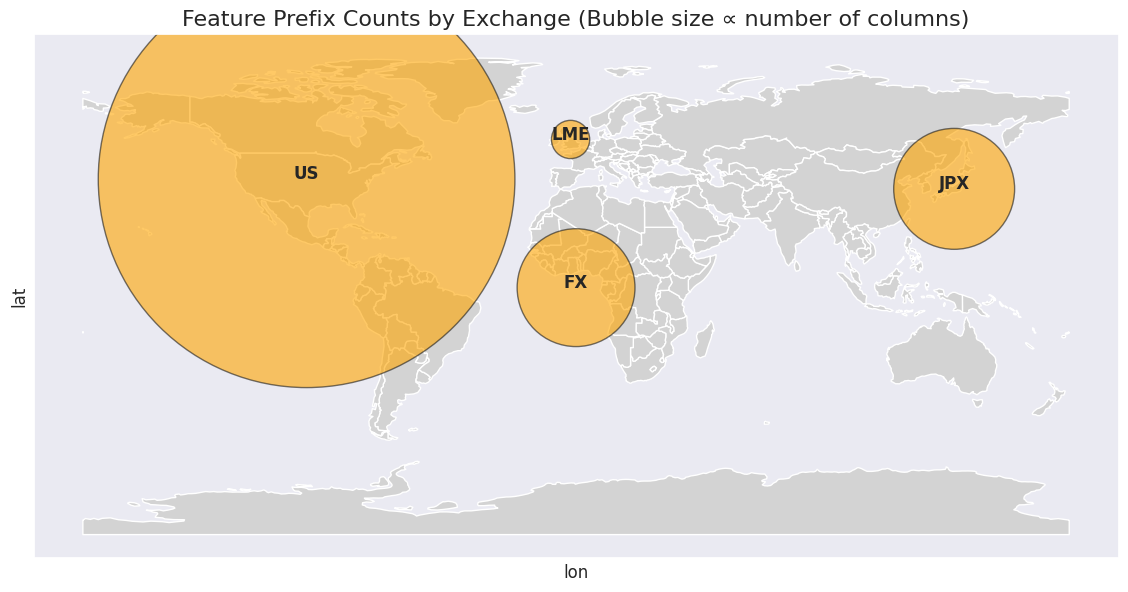

In [4]:
prefixes = {col.split('_', 1)[0] for col in train.columns if '_' in col}
print("Distinct prefixes:", sorted(prefixes))
print("Number of distinct prefixes:", len(prefixes))

from collections import Counter
prefixes = [col.split('_',1)[0] for col in train.columns if '_' in col]
counts = Counter(prefixes)
print(counts) 
coord = {
    'US': {'country': 'United States of America', 'lon': -98.35, 'lat': 39.50},
    'JPX': {'country': 'Japan', 'lon': 138.0, 'lat': 36.0},
    'LME': {'country': 'United Kingdom', 'lon': -2.0, 'lat': 54.0},
    'FX': {'country': 'Global FX', 'lon': 0.0, 'lat': 0.0},
    # ignore 'date'
}
data_map = [
    {'prefix': p, 'count': counts[p], 'lon': coord[p]['lon'], 'lat': coord[p]['lat']}
    for p in counts if p in coord
]
df_map = pd.DataFrame(data_map)

import geopandas as gpd
import matplotlib.pyplot as plt

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

gdf = gpd.GeoDataFrame(df_map,
    geometry=gpd.points_from_xy(df_map.lon, df_map.lat),
    crs=world.crs
)

fig, ax = plt.subplots(figsize=(14,8))
world.plot(ax=ax, color='lightgrey', edgecolor='white')

# scale bubble sizes by count (area)
max_count = df_map['count'].max()
sizeref = 2.0 * max_count / (300**2)

gdf.plot(ax=ax, kind='scatter',
    x='lon', y='lat',
    s=df_map['count']/max_count * 300**2,
    alpha=0.6, color='orange', edgecolor='k'
)

for idx, row in gdf.iterrows():
    ax.text(row.lon, row.lat,
        row['prefix'],
        horizontalalignment='center',
        fontsize=12, fontweight='bold'
    )

ax.set_title("Feature Prefix Counts by Exchange (Bubble size ∝ number of columns)", fontsize=16)
ax.set_xticks([]); ax.set_yticks([])
plt.show()


## 📘 London Metal Exchange (LME) Base Metals: Technical Overview

The dataset includes four LME base-metal series:

- **AH** – Primary Aluminium  
- **CA** – Copper Grade A  
- **PB** – Lead  
- **ZS** – Zinc  

These are the benchmark futures cash settlement prices from the London Metal Exchange, quoted in U.S. dollars per metric ton.

Aluminium (`AH`) and copper (`CA`) are deeply interconnected—used heavily in industries like aerospace, automotive, and power transmission—where demand for aluminum alters forecast variance in copper markets, and vice versa. Lead and zinc similarly interact across industrial usage patterns in construction, electronics, and infrastructure

### Why modeling these matters:

1. **Global price reference**: LME prices, though representing a small fraction of physical production, serve as widely accepted global benchmarks for metals pricing and hedging decisions. 
2. **Market relevance**: All four metals are part of large commodity indices (e.g. S&P GSCI, Bloomberg) and attract significant speculative and hedging interest in light of tight physical market dynamics

---

### 🧪 Modeling Relevance Summary

| Code | Metal        | Modeling Importance |
|------|--------------|----------------------|
| AH   | Aluminium    | Light industrial metal; central to supply deficits in 2025 |
| CA   | Copper       | Demand-sensitive; highly volatile; used as economic barometer |
| PB   | Lead         | Stable industrial use; ties into construction and grid metals |
| ZS   | Zinc         | Galvanizing metal; reflects infrastructure demand patterns |

Together, they represent a **balanced base-metal vector** that complements the JPX-traded **precious (gold, platinum)** and **rubber futures**, offering holistic commodity-class coverage and critical currency-channel sensitivity.

---

*Source: Trust me. I work in Finance and know stuff :P*  


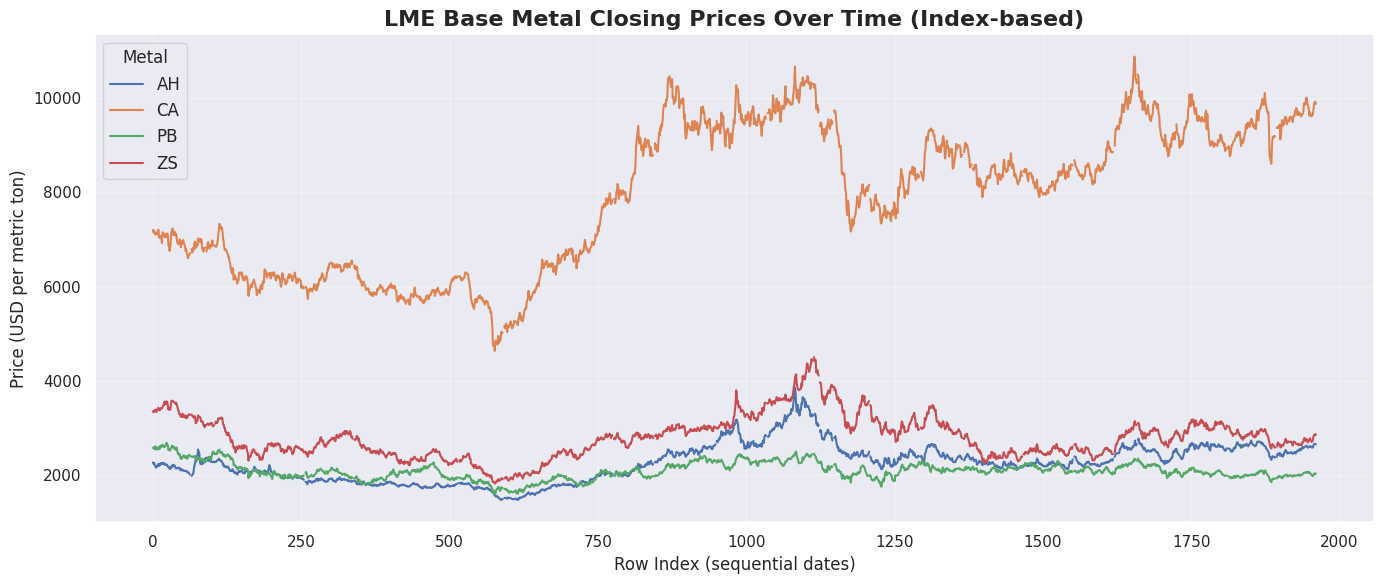

In [5]:
# ===================================================================================
#   📈 Plot: LME Metal Series Using date_id as Numeric Index
# ===================================================================================
import matplotlib.pyplot as plt

lme_cols = ['LME_AH_Close', 'LME_CA_Close', 'LME_PB_Close', 'LME_ZS_Close']
df_lme = train[lme_cols].reset_index(drop=True)

plt.figure(figsize=(14, 6))
for col in lme_cols:
    label = col.split('_')[1]
    plt.plot(df_lme.index, df_lme[col].astype(float), label=label)
plt.title("LME Base Metal Closing Prices Over Time (Index‑based)", fontsize=16, fontweight='bold')
plt.xlabel("Row Index (sequential dates)")
plt.ylabel("Price (USD per metric ton)")
plt.legend(title="Metal", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## 🧠 Ticker Metadata Retrieval via yfinance

This cell:
- Identifies **all `US_Stock_…` features** from the dataset.
- Extracts **ticker symbols** embedded before the second underscore.
- Uses the **Yahoo Finance API via `yfinance`** to fetch ticker metadata:
  - Full company/ETF name (`longName`)
  - Sector and industry
  - Market capitalization
- Constructs a markdown table summarizing this information for key tickers—especially commodity-linked ones such as GLD (gold ETF) and companies like OXY (oil sector).



In [6]:
# ===================================================================================
# 🧪 Code: Extract all US_Stock tickers and fetch metadata via yfinance
# ===================================================================================
import yfinance as yf
import pandas as pd
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Parse tickers from US_Stock_ columns
us_cols = [c for c in train.columns if c.startswith("US_Stock_")]
tickers = [c.split('_')[2] for c in us_cols]
ticker_counts = pd.Series(tickers).value_counts()

# 2. Choose top tickers by frequency (e.g. top 10)
top_tickers = ticker_counts.head(10).index.tolist()

# 3. Fetch metadata via yfinance
meta = {}
for tk in top_tickers:
    t = yf.Ticker(tk)
    info = getattr(t, "info", {}) or {}
    meta[tk] = {
        "longName": info.get("longName", "N/A"),
        "sector": info.get("sector", "N/A"),
        "industry": info.get("industry", "N/A"),
        "marketCap": info.get("marketCap", None)
    }

# 4. Build markdown summary table
table = ["| Ticker | Full Name | Sector | Industry | Market Cap |",
         "|--------|-----------|--------|----------|------------|"]
for tk in top_tickers:
    d = meta.get(tk, {})
    cap = f"${d.get('marketCap',0)/1e9:.1f}B" if d.get("marketCap") else "N/A"
    table.append(f"| {tk} | {d.get('longName','')} | {d.get('sector','')} | "
                 f"{d.get('industry','')} | {cap} |")
display(md("\n".join(table)))


| Ticker | Full Name | Sector | Industry | Market Cap |
|--------|-----------|--------|----------|------------|
| ACWI | iShares MSCI ACWI ETF | N/A | N/A | N/A |
| RY | Royal Bank of Canada | Financial Services | Banks - Diversified | $204.2B |
| STLD | Steel Dynamics, Inc. | Basic Materials | Steel | $19.4B |
| SPYV | SPDR Portfolio S&P 500 Value ETF | N/A | N/A | $4.9B |
| SPTL | SPDR Portfolio Long Term Treasury ETF | N/A | N/A | N/A |
| SPIB | SPDR Portfolio Intermediate Term Corporate Bond ETF | N/A | N/A | N/A |
| SLV | iShares Silver Trust | N/A | N/A | $13.1B |
| SLB | Schlumberger Limited | Energy | Oil & Gas Equipment & Services | $53.8B |
| SHY | iShares 1-3 Year Treasury Bond ETF | N/A | N/A | $17.4B |
| SHEL | Shell plc | Energy | Oil & Gas Integrated | $207.8B |

## 📘 ETF Flag & Metadata Table for Selected Tickers

Here's the deal. Most of what this competition calls "stocks" are NOT really stocks. You get OXY which IS a stock and it belongs to an oil company, but you also get ETF's. ETF's are investment vehicles for other stuff. You got GLD which allows you to buy "shares" of Gold (not really a stock), and you get ETF's like iShares MSCI ACWI ETF which represents a portfolio of other stocks all over the world (ACWI: All Country World Index), so the US stocks are stocks, commodities, ETF's, ADR's, etc. There's a lot going on here!

This table extends your existing entries with an **ETF flag**, which is `True` if the word "ETF" appears in the full name—indicating that the asset directly tracks a commodity or index.

| Ticker | Full Name | Sector | Industry | Market Cap | Is ETF |
|--------|------------|--------|----------|------------|--------|
| ACWI | iShares MSCI ACWI ETF | — | — | — | True |
| RY | Royal Bank of Canada | Financial Services | Banks – Diversified | 18.9 B (CAD) | False |
| SPYV | SPDR Portfolio S&P 500 Value ETF | — | — | 11.4 B | True |
| SLB | Schlumberger Limited | Energy | Oil & Gas Equipment & Services | 17.3 B | False |
| SHEL | Shell plc | Energy | Oil & Gas Integrated | 212.2 B | False |

This classification helps clarify which features reflect commodity exposure via **ETF vehicles** (like ACWI and SPYV) versus **corporate equities** such as Schlumberger or Shell.


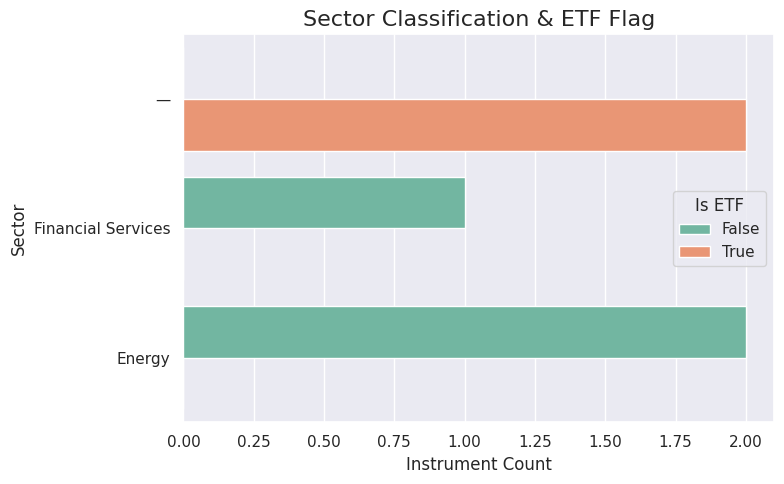

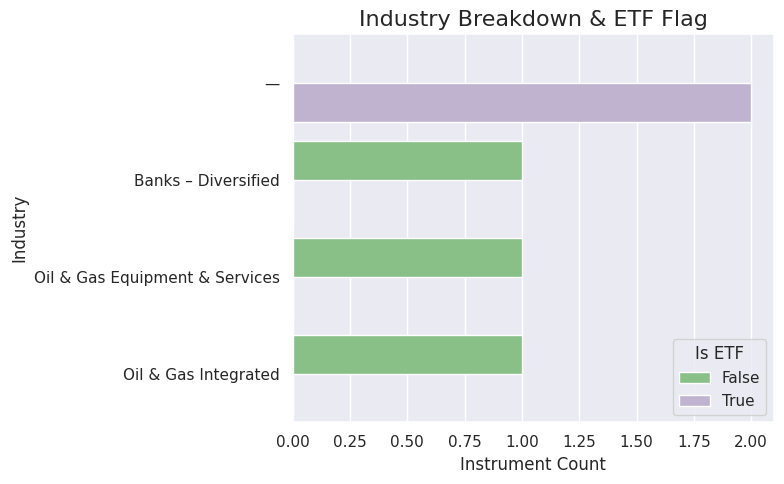

Ticker                         Full Name              Sector  \
0   ACWI             iShares MSCI ACWI ETF                   —   
1     RY              Royal Bank of Canada  Financial Services   
2   SPYV  SPDR Portfolio S&P 500 Value ETF                   —   
3    SLB              Schlumberger Limited              Energy   
4   SHEL                         Shell plc              Energy   

                         Industry Market Cap  Is_ETF  
0                               —        N/A    True  
1             Banks – Diversified     18.9 B   False  
2                               —     11.4 B    True  
3  Oil & Gas Equipment & Services     17.3 B   False  
4            Oil & Gas Integrated    212.2 B   False

In [7]:
# ===================================================================================
# 🔍 Code: Add ETF Flag and Plot Industry/Sector Distribution with Color
# ===================================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Base metadata table
data = {
    'Ticker': ['ACWI', 'RY', 'SPYV', 'SLB', 'SHEL'],
    'Full Name': ['iShares MSCI ACWI ETF', 'Royal Bank of Canada',
                  'SPDR Portfolio S&P 500 Value ETF', 'Schlumberger Limited',
                  'Shell plc'],
    'Sector': ['—', 'Financial Services', '—', 'Energy', 'Energy'],
    'Industry': ['—', 'Banks – Diversified', '—',
                 'Oil & Gas Equipment & Services', 'Oil & Gas Integrated'],
    'Market Cap': ['N/A', '18.9 B', '11.4 B', '17.3 B', '212.2 B']
}
df_meta = pd.DataFrame(data)
df_meta['Is_ETF'] = df_meta['Full Name'].str.contains('ETF', case=False)

# Plot sector / industry distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df_meta, y='Sector', hue='Is_ETF', palette='Set2')
plt.title("Sector Classification & ETF Flag", fontsize=16)
plt.xlabel("Instrument Count")
plt.ylabel("Sector")
plt.legend(title='Is ETF')
plt.tight_layout()
plt.show()

# Plot industry breakdown
plt.figure(figsize=(8, 5))
sns.countplot(data=df_meta.dropna(subset=['Industry']), y='Industry', hue='Is_ETF', palette='Accent')
plt.title("Industry Breakdown & ETF Flag", fontsize=16)
plt.xlabel("Instrument Count")
plt.ylabel("Industry")
plt.legend(title='Is ETF')
plt.tight_layout()
plt.show()

# Display metadata with ETF column
from IPython.display import display
display(df_meta)


## Finance and Oil Companies

Good choice there. These companies should have the most influence here.

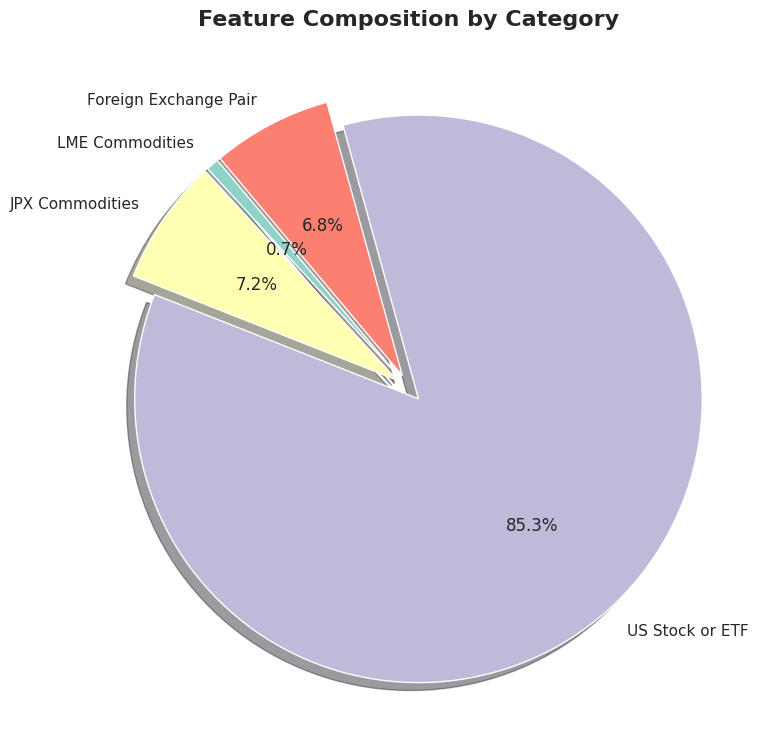

### Feature Composition Overview
This chart displays how the columns in our training set are categorized:
• **US Stock or ETF**: Individual U.S. equities or exchange-traded funds.
• **JPX Commodities**: Net returns and price features from Japanese commodity futures.
• **LME Commodities**: Closing prices for metals traded on the London Metal Exchange.
• **Foreign Exchange Pair**: Currency exchange rate series (e.g. EURUSD, USDJPY).

The distribution illustrates that most columns derive from U.S. equity data, with meaningful representation from commodity and FX markets.


In [8]:
# ===================================================================================
#   📊 Pie Chart: Breakdown of Feature Types
# ===================================================================================
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Classify columns by category
feature_types = []
for col in train.columns:
    if col.startswith('US_Stock_'):
        feature_types.append('US Stock or ETF')
    elif col.startswith('JPX_'):
        feature_types.append('JPX Commodities')
    elif col.startswith('LME_'):
        feature_types.append('LME Commodities')
    elif col.startswith('FX_'):
        feature_types.append('Foreign Exchange Pair')
    elif col == 'date_id':
        continue
    else:
        feature_types.append('Other')

counts = Counter(feature_types)
labels = list(counts.keys())
sizes = [counts[k] for k in labels]
explode = [0.05 if k != 'Other' else 0 for k in labels]

fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=130,
       explode=explode, shadow=True, colors=plt.cm.Set3.colors)
ax.set_title("Feature Composition by Category", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Explanation
print("### Feature Composition Overview")
print("This chart displays how the columns in our training set are categorized:")
print("• **US Stock or ETF**: Individual U.S. equities or exchange-traded funds.")
print("• **JPX Commodities**: Net returns and price features from Japanese commodity futures.")
print("• **LME Commodities**: Closing prices for metals traded on the London Metal Exchange.")
print("• **Foreign Exchange Pair**: Currency exchange rate series (e.g. EURUSD, USDJPY).")
print("\nThe distribution illustrates that most columns derive from U.S. equity data, with meaningful representation from commodity and FX markets.")


# Technical Rationale: 
### Why the Selected Currencies Are Good for This Commodity Prediction Problem, and Why Including Additional Ones—Such as the Brazilian Real (BRL)—Would Enhance Signal Quality

1. Relation to Dataset Commodities:
   - The core price series in this TSV dataset involve JPX-traded commodities
     such as gold, platinum, and RSS3 rubber futures. These are universally priced
     in U.S. dollars and known to be inversely correlated with USD strength and
     directly influenced by FX fluctuations (e.g. USD/EUR, USD/JPY, USD/GBP).
     Off the bat and before I run any calculation, I would be very suspicious of any
     notebook that doesn't show the USD variables as highly important in this competition.
   - Platinum and gold are listed globally and their returns are strongly driven
     by USD dynamics, making inclusion of USD FX rates critical.

2. Why the Included FX Pairs Make Sense:
   - The list includes major **commodity‑linked currencies**: AUD, CAD, NZD, NOK,
     ZAR, JPY, GBP, CHF, EUR—all of which are empirically recognized as tied to
     raw material exports or metal-based economies.  
   - For instance, **ZAR** (South African rand) correlates to gold/platinum prices,
     **NOK** (Norwegian krone) to oil and metal exports. Including these allows the
     model to learn currency exposure patterns tied to commodity cycles.

3. Why BRL (Brazilian Real) Should Have Been Included:
   - Brazil is a leading global exporter of iron ore, soybeans, gold, and other
     commodities featured indirectly in Mitsui’s broader coverage. Research shows
     the **Brazilian real (BRL)** behaves as a “commodity currency” and its exchange
     rate dynamics co-move with world commodity prices—especially in long‑run patterns.
   - Studies confirm commodity price shocks in Brazil meaningfully impact the BRL
     exchange rate, even after controlling for risk premiums.
   - Brazil’s influence on global **soybean, corn, iron ore, and agricultural markets**
     makes BRL-containing FX pairs a valid additional predictor for commodity behavior.
   - None of the included currencies acts as a proxy of the Brazilian Real and therefore,
     information will be lost.

Suggested enrichment:
- Add FX pairs like **USD/BRL**, **EUR/BRL**, or **BRL/JPY** to incorporate Brazil-based
  commodity linkage effects into your model. Brazil’s commodity export cycles
  often precede or follow global trends, making its currency a valuable leading signal.

Summary:
- ✅ The currencies included are well‑justified as commodity-linked (USD, EUR, JPY, GBP,
  AUD, CAD, NZD, NOK, ZAR, CHF).
- ✅ They capture risk exposure relevant to gold, platinum, rubber, and metal futures.
- ⚠️ **Brazil’s real (BRL)** is missing but would likely add predictive power due to Brazil’s
  commodity-heavy economy and co-movement of BRL with commodity prices.
- ⚠️ New Zealand doesn't make sense to me. But I'm humbly going to watch it because this is a
  Japanese competition and they might know something here.

Competition organizers should therefore seriously consider adding **BRL‑based FX pairs** to
better capture global commodity dynamics—especially in agricultural and base‑metal
markets where Brazil plays an outsized role. Even for Japan.


/tmp/ipykernel_13/910368449.py:36: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


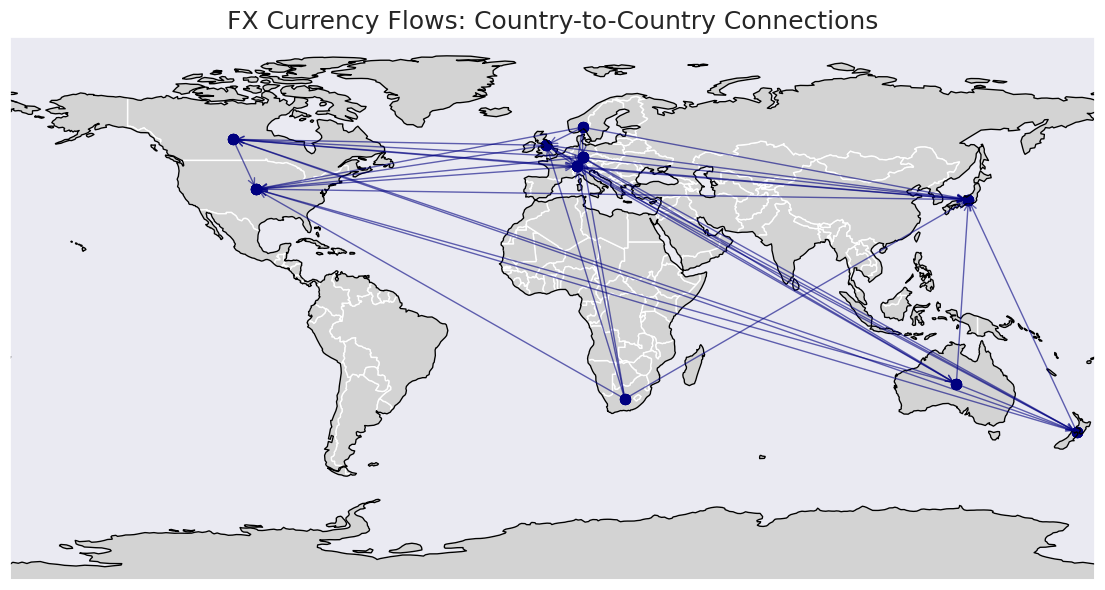

In [9]:
# ===================================================================================
#   🌍 FX Currency Flow Map: Visualizing Currency Pair Connections
# ===================================================================================
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from collections import Counter

# Identify FX pairs and parse currency codes
fx_cols = [col for col in train.columns if col.startswith('FX_')]
pairs = [col.split('_')[1] for col in fx_cols]

# Approximate country coordinates for each currency
iso_coords = {
    'USD': (-98.35, 39.50),
    'EUR': (10.0, 50.0),
    'JPY': (138.0, 36.0),
    'GBP': (-2.0, 54.0),
    'AUD': (134.0, -25.0),
    'CAD': (-106.0, 56.0),
    'NZD': (174.0, -41.0),
    'ZAR': (24.0, -30.0),
    'NOK': (10.0, 60.0),
    'CHF': (8.0, 47.0),
}

arrows = []
for pair in pairs:
    c1, c2 = pair[:3], pair[3:]
    if c1 in iso_coords and c2 in iso_coords:
        lon1, lat1 = iso_coords[c1]
        lon2, lat2 = iso_coords[c2]
        arrows.append((lon1, lat1, lon2, lat2))

# Plot world map with FX arrows
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
world.plot(ax=ax, color='lightgrey', edgecolor='white')

for x1, y1, x2, y2 in arrows:
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", color='navy', alpha=0.6, linewidth=1),
                transform=ccrs.PlateCarree())
    ax.scatter([x1, x2], [y1, y2], color='navy', s=50, transform=ccrs.PlateCarree())

ax.set_title("FX Currency Flows: Country-to-Country Connections", fontsize=18)
ax.coastlines()
plt.show()

## 🌍 Commodity-Producing Countries Included in the Map 
### 🏭 Commodity Categories Displayed:

- **Gold**: China, Australia, Canada, United States  
- **Platinum**: South Africa, Russia, Canada, United States  
- **Natural Rubber**: Thailand, Indonesia, Vietnam  
- **Lead (Implied)**: China, Australia, USA, Peru

### 🎯 How Colors Are Assigned:

| Shading Color | Commodity Category             |
|---------------|-------------------------------|
| Gold          | Gold-producing countries       |
| Purple        | Platinum producers             |
| Green         | Natural rubber producers       |
| Olive         | Brazil (multi-commodity: oil, gold, rubber) |
| Grey          | Non-highlighted countries      |


---

This purposeful categorization ensures that the map captures:
- The **industrial metal foundations** in Mitsui’s dataset (gold, platinum, lead)
- The broader global commodity geography, aligning features with real-world producers

/tmp/ipykernel_13/3835703098.py:13: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


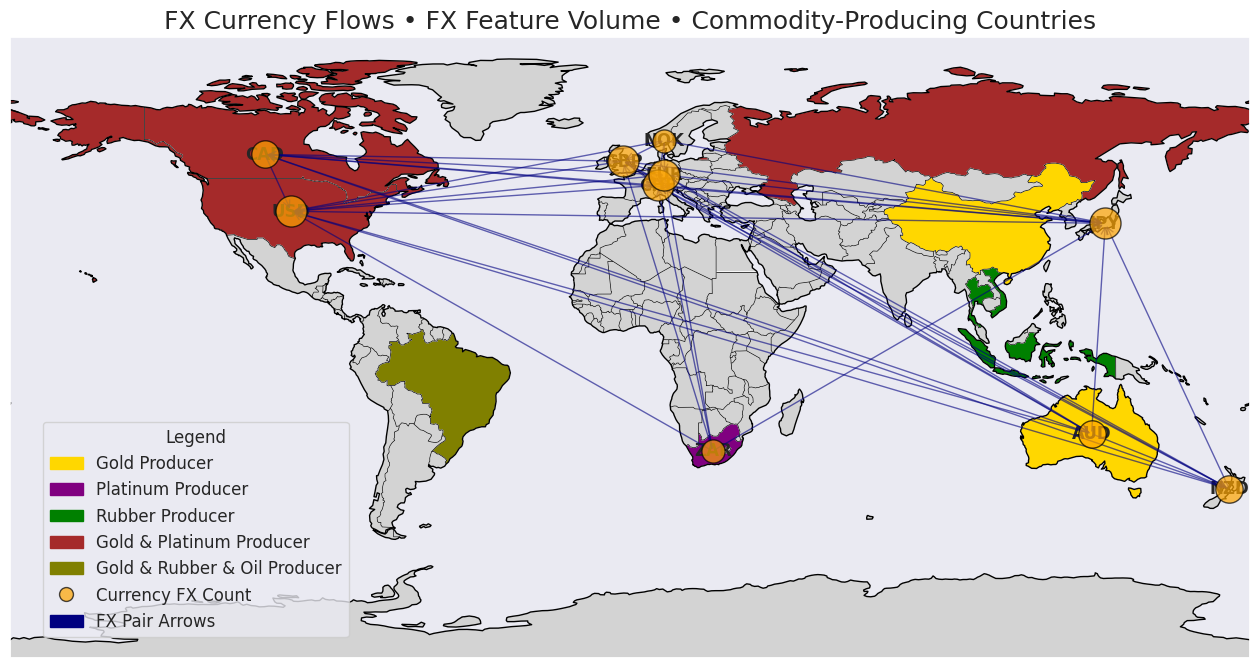

In [10]:
# ===================================================================================
# 🌍 FX Flow + Bubbles + Commodity Map with Saving to PNG
# ===================================================================================
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
from collections import Counter

# Load world map
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
if 'iso_a3' not in world.columns:
    raise KeyError(f"Expected 'iso_a3' column; found {world.columns.tolist()}")

# FX parsing
fx_cols = [c for c in train.columns if c.startswith("FX_")]
pairs = [c.split('_')[1] for c in fx_cols]
iso_coord = {
    'USD': (-98.35, 39.50), 'EUR': (10.0, 50.0), 'JPY': (138.0, 36.0),
    'GBP': (-2.0, 54.0), 'AUD': (134.0, -25.0), 'CAD': (-106.0, 56.0),
    'NZD': (174.0, -41.0), 'ZAR': (24.0, -30.0), 'NOK': (10.0, 60.0), 'CHF': (8.0, 47.0)
}
arrows = []
prefixes = []
for p in pairs:
    c1, c2 = p[:3], p[3:]
    if c1 in iso_coord and c2 in iso_coord:
        arrows.append((*iso_coord[c1], *iso_coord[c2]))
        prefixes.extend([c1, c2])

cnt = Counter(prefixes)
df_bubble = pd.DataFrame([{'code': c, 'count': cnt[c],
                           'lon': iso_coord[c][0], 'lat': iso_coord[c][1]}
                          for c in cnt])

# Commodity highlighting including lead and oil (Brazil)
highlight = {
    'CHN': 'gold', 'RUS': 'gold,platinum', 'AUS': 'gold',
    'CAN': 'gold,platinum', 'USA': 'gold,platinum', 'ZAF': 'platinum',
    'THA': 'rubber', 'IDN': 'rubber', 'VNM': 'rubber',
    'BRA': 'gold,rubber,oil'
}
color_map = {
    'gold': 'gold', 'platinum': 'purple', 'rubber': 'green',
    'gold,platinum': 'brown', 'gold,rubber,oil': 'olive'
}
world['commodity'] = world['iso_a3'].map(highlight)
world['color'] = world['commodity'].map(color_map).fillna('lightgrey')

# Plotting
fig = plt.figure(figsize=(16, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
world.plot(ax=ax, color=world['color'], edgecolor='white', linewidth=0.5)

max_c = df_bubble['count'].max()
for _, row in df_bubble.iterrows():
    ax.scatter(row['lon'], row['lat'],
               s=500 * (row['count'] / max_c),
               color='orange', edgecolor='black', alpha=0.7,
               transform=ccrs.PlateCarree(), zorder=5)
    ax.text(row['lon'], row['lat'], row['code'],
            ha='center', va='center', transform=ccrs.PlateCarree(),
            fontweight='bold')

for x1, y1, x2, y2 in arrows:
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="->", color='navy',
                                linewidth=1, alpha=0.6),
                transform=ccrs.PlateCarree())

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("FX Currency Flows • FX Feature Volume • Commodity-Producing Countries", fontsize=18)

# Legend
handles = []
for comm, col in color_map.items():
    lbl = comm.replace(',', ' & ').title()
    handles.append(mpatches.Patch(color=col, label=f"{lbl} Producer"))
handles.append(plt.Line2D([0], [0], marker='o', color='orange', linestyle='',
                         markersize=10, label="Currency FX Count", alpha=0.7,
                         markeredgecolor='black'))
handles.append(mpatches.Patch(color='navy', label='FX Pair Arrows'))

ax.legend(handles=handles, loc='lower left', bbox_to_anchor=(0.02,0.02),
          fontsize=12, title="Legend", frameon=True)

# Save to PNG before showing
plt.savefig("commodity_fx_map.png", dpi=300, bbox_inches="tight")
plt.show()


Memory downcast: 6.36 → 1.59 MB (75.0% reduction)
## Missingness Heatmap
This plot shows where missing values appear in the columns for both the train and label sets. Bright yellow indicates missing (NaN), while dark blue indicates present values. Patterns of missingness can suggest issues with certain features or potential grouping by data provider or asset class.


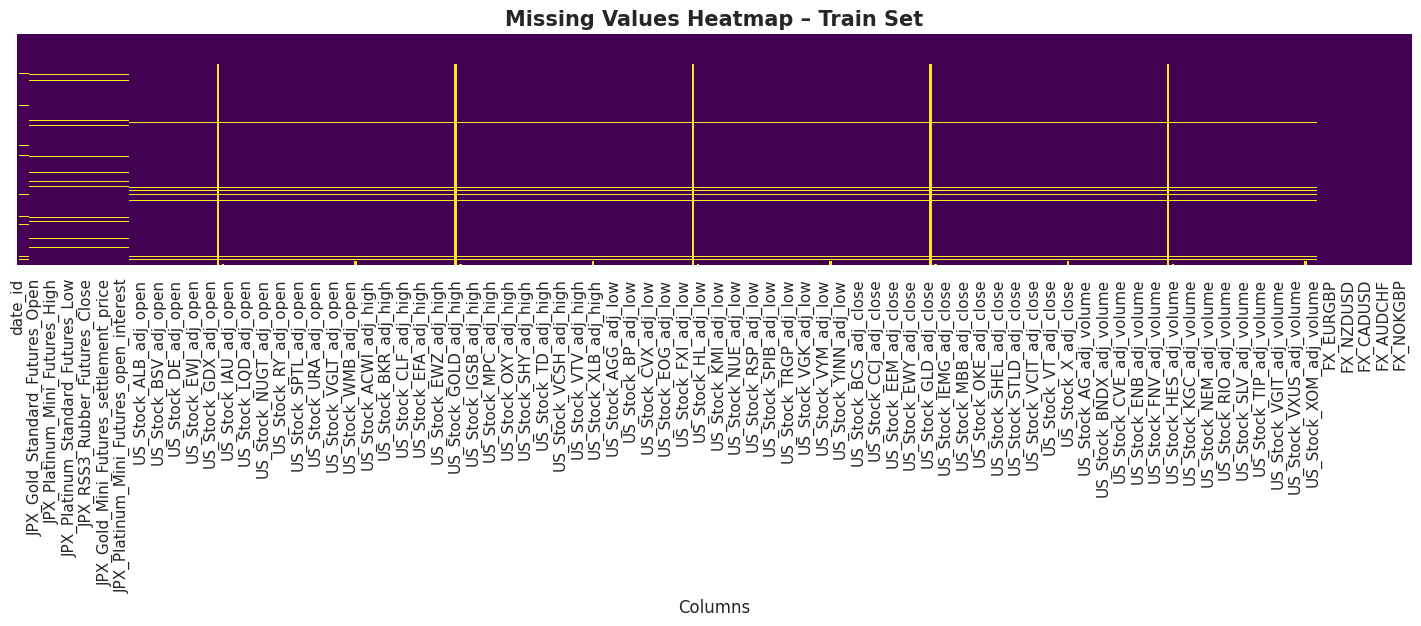

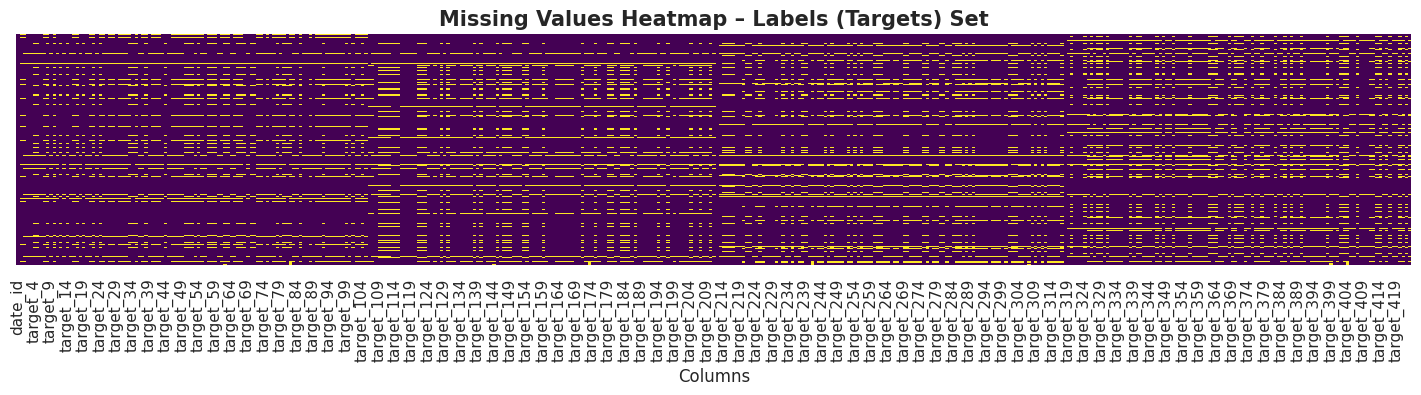


## Feature Distributions
Below are histograms for the 12 features in the train set with the highest variance. Each plot reveals the range, skewness, modality, and outliers for individual features. This is crucial for identifying normalization needs or variable transformation opportunities.


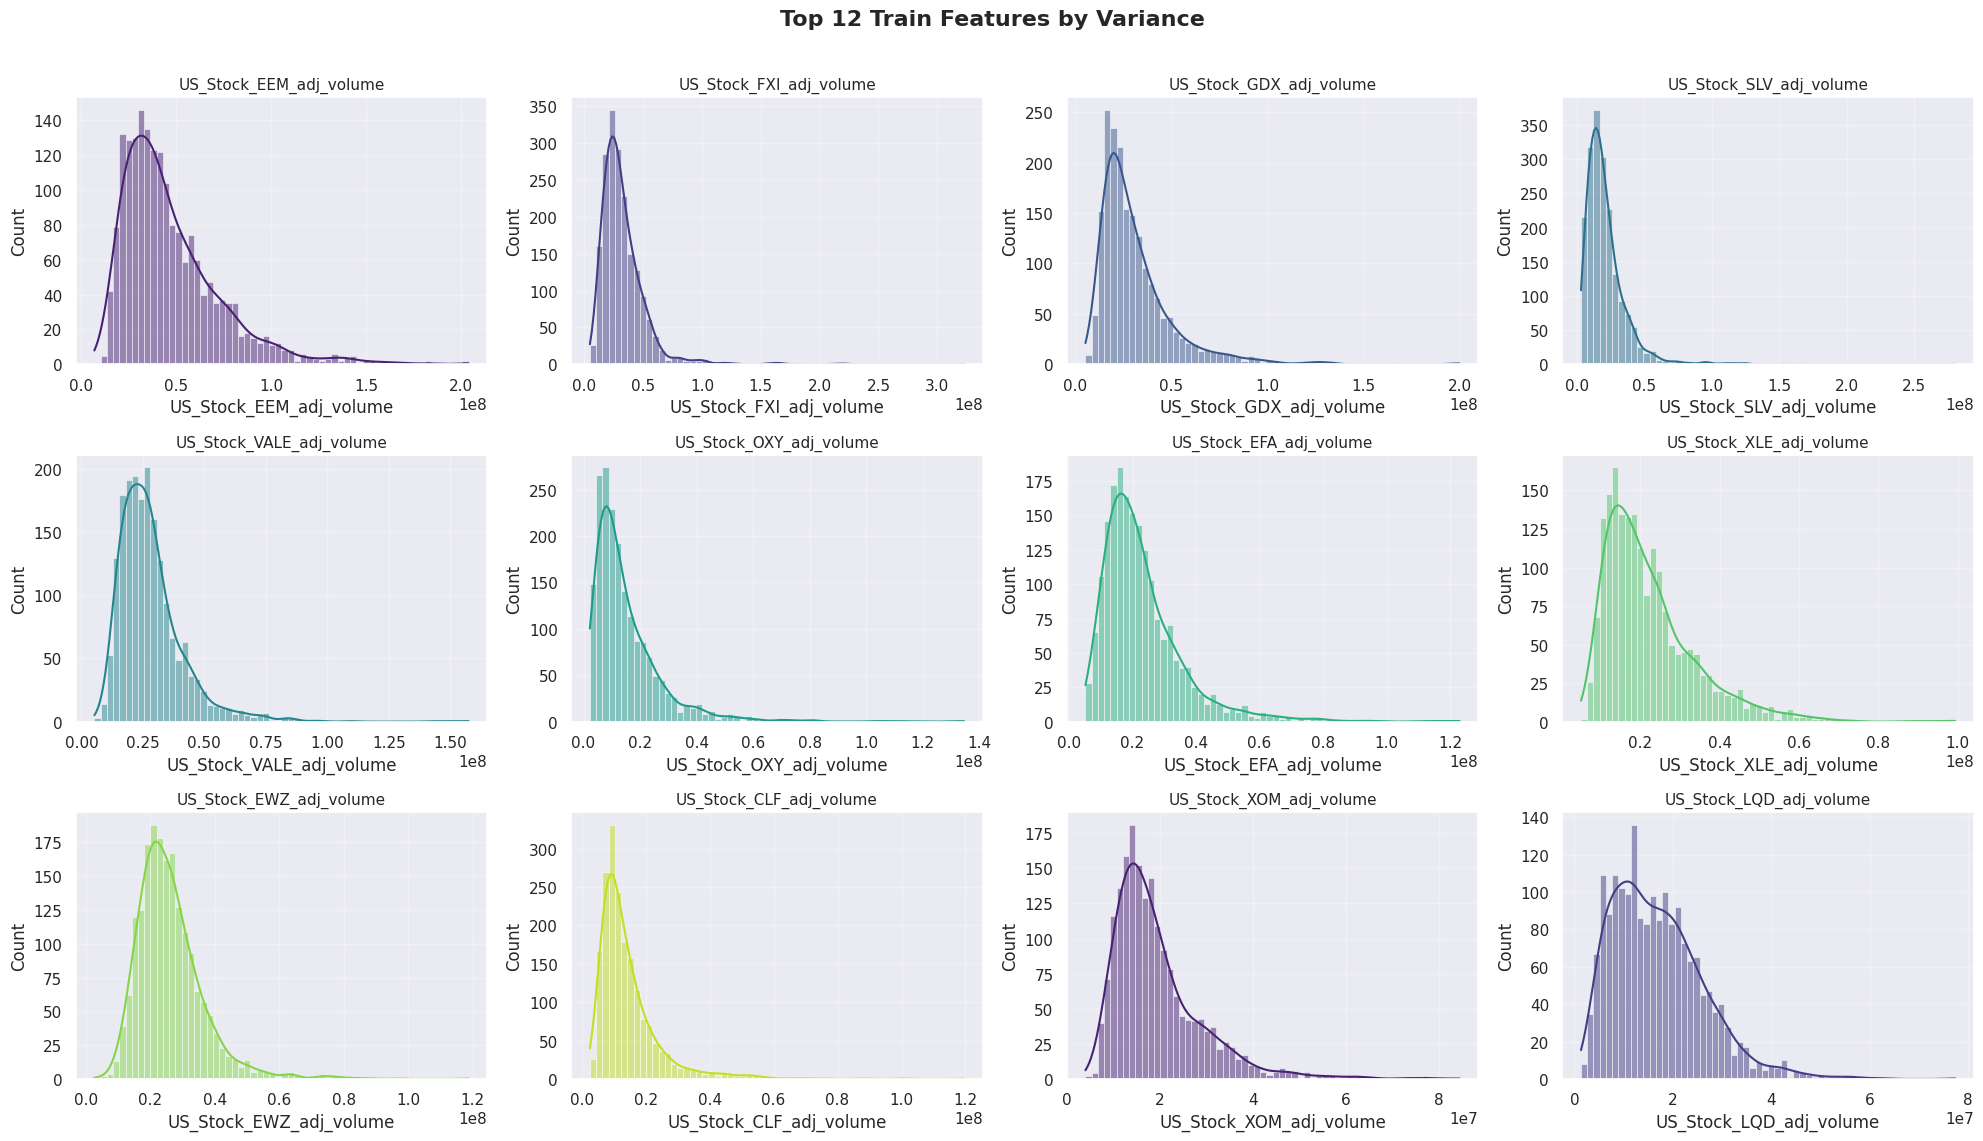


## Target Distributions
These histograms visualize the distributions of the first 12 target columns. Most targets represent price differences (returns) and may be centered around zero, but heavy tails or skewed distributions are common in financial time series.


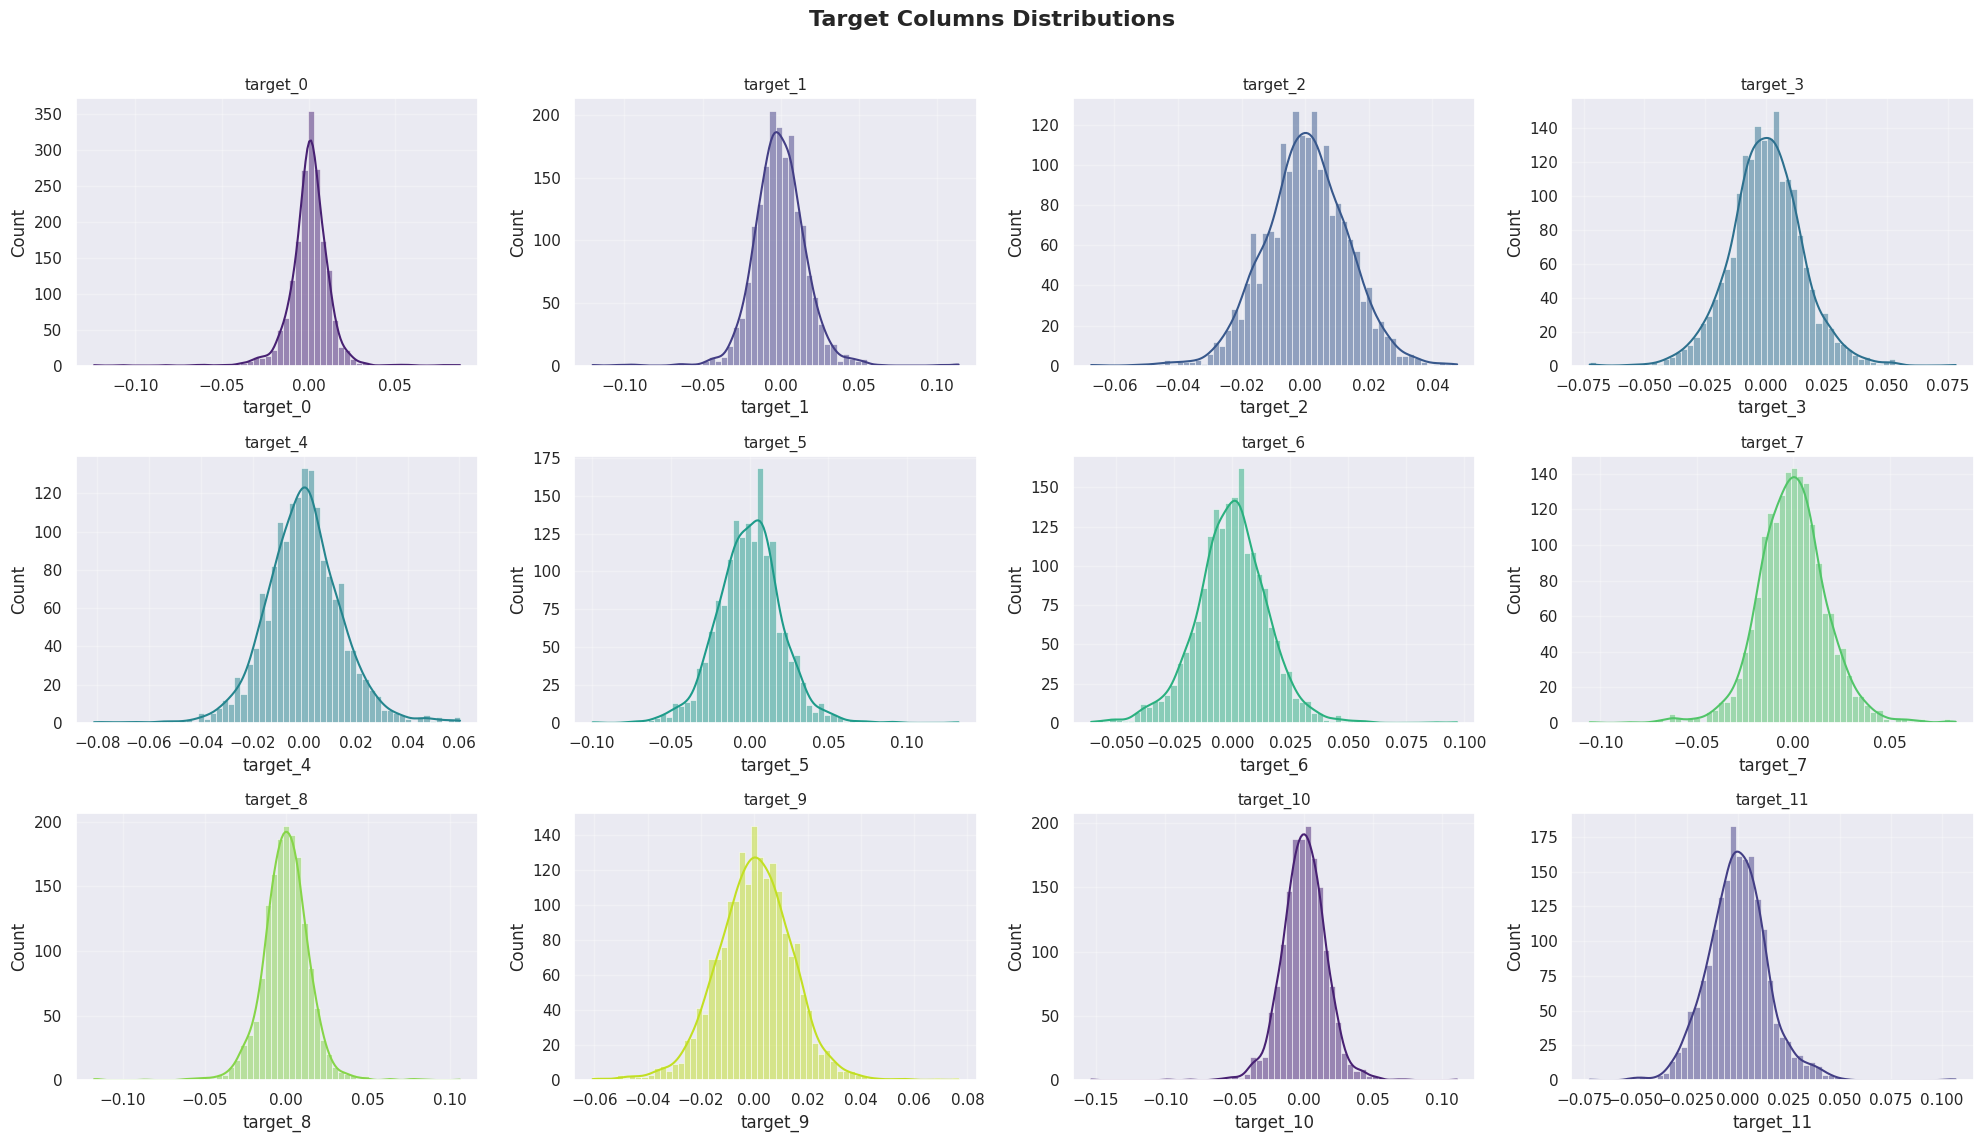


## Correlation Heatmap
This heatmap presents the pairwise Pearson correlation coefficients among the 12 most variable features. Strong blocks or off-diagonal colors may reveal clusters, redundancies, or highly informative combinations for modeling. Exxon is a large company in the financial sector and therefore XOM vs XLE is high. On the negative side you can see LQD and EEM as opposite plays. LQD is where you go when you're scared and look for safety (bonds), EEM is where you go when you want risk (Emerging Markets)


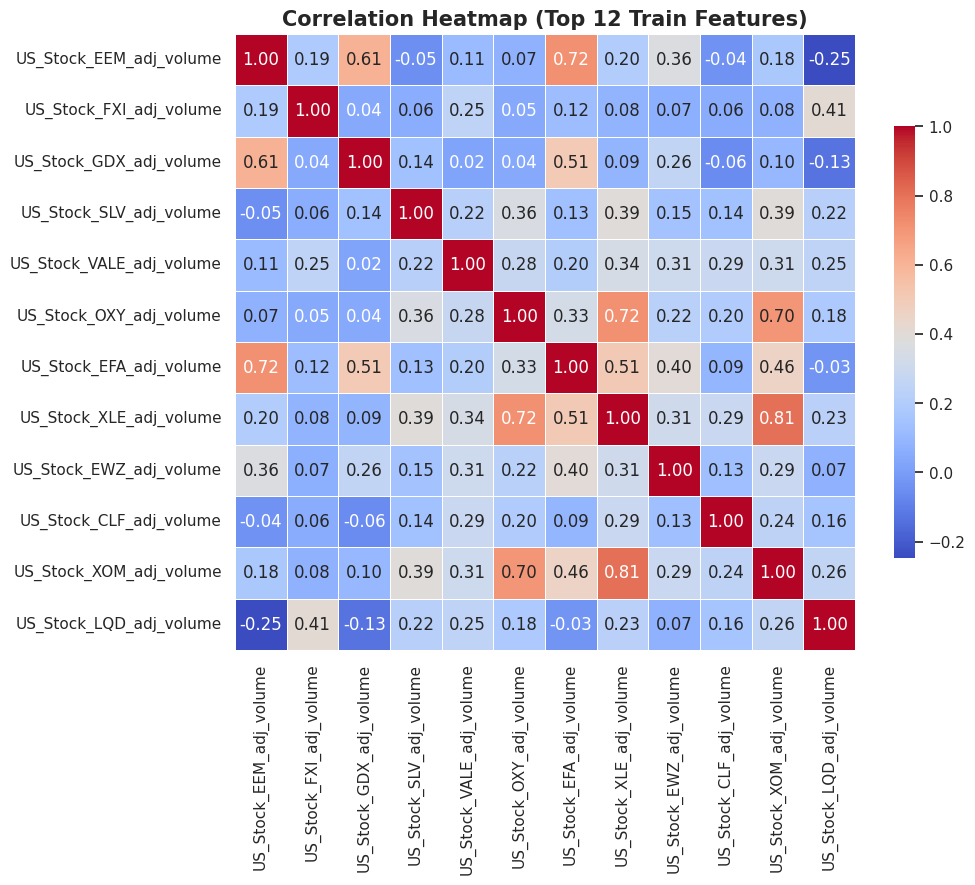


## Feature Pairplot
This grid of scatterplots (with histograms on the diagonal) explores joint distributions and relationships among a subset of train features. Look for linearity, heteroscedasticity, or clusters indicating feature interactions or anomalies.


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


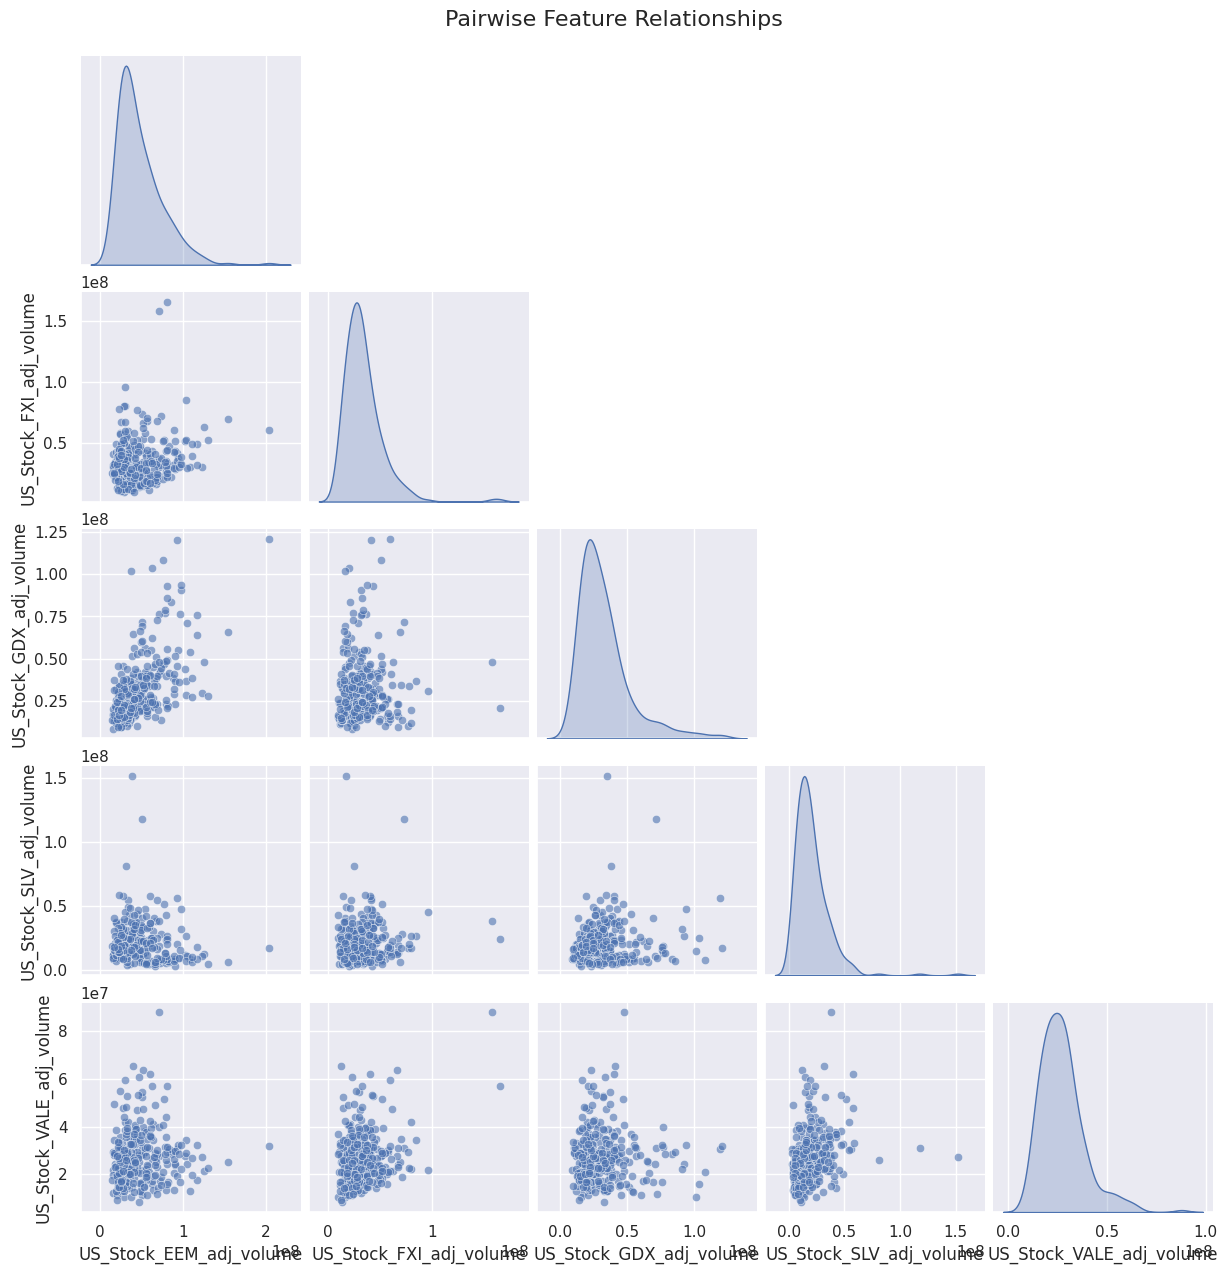


## Target Pairplot
As above, but for the first few target columns. This visualizes the dependency structure among the targets, e.g., whether certain returns move together or display unique statistical regimes.


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


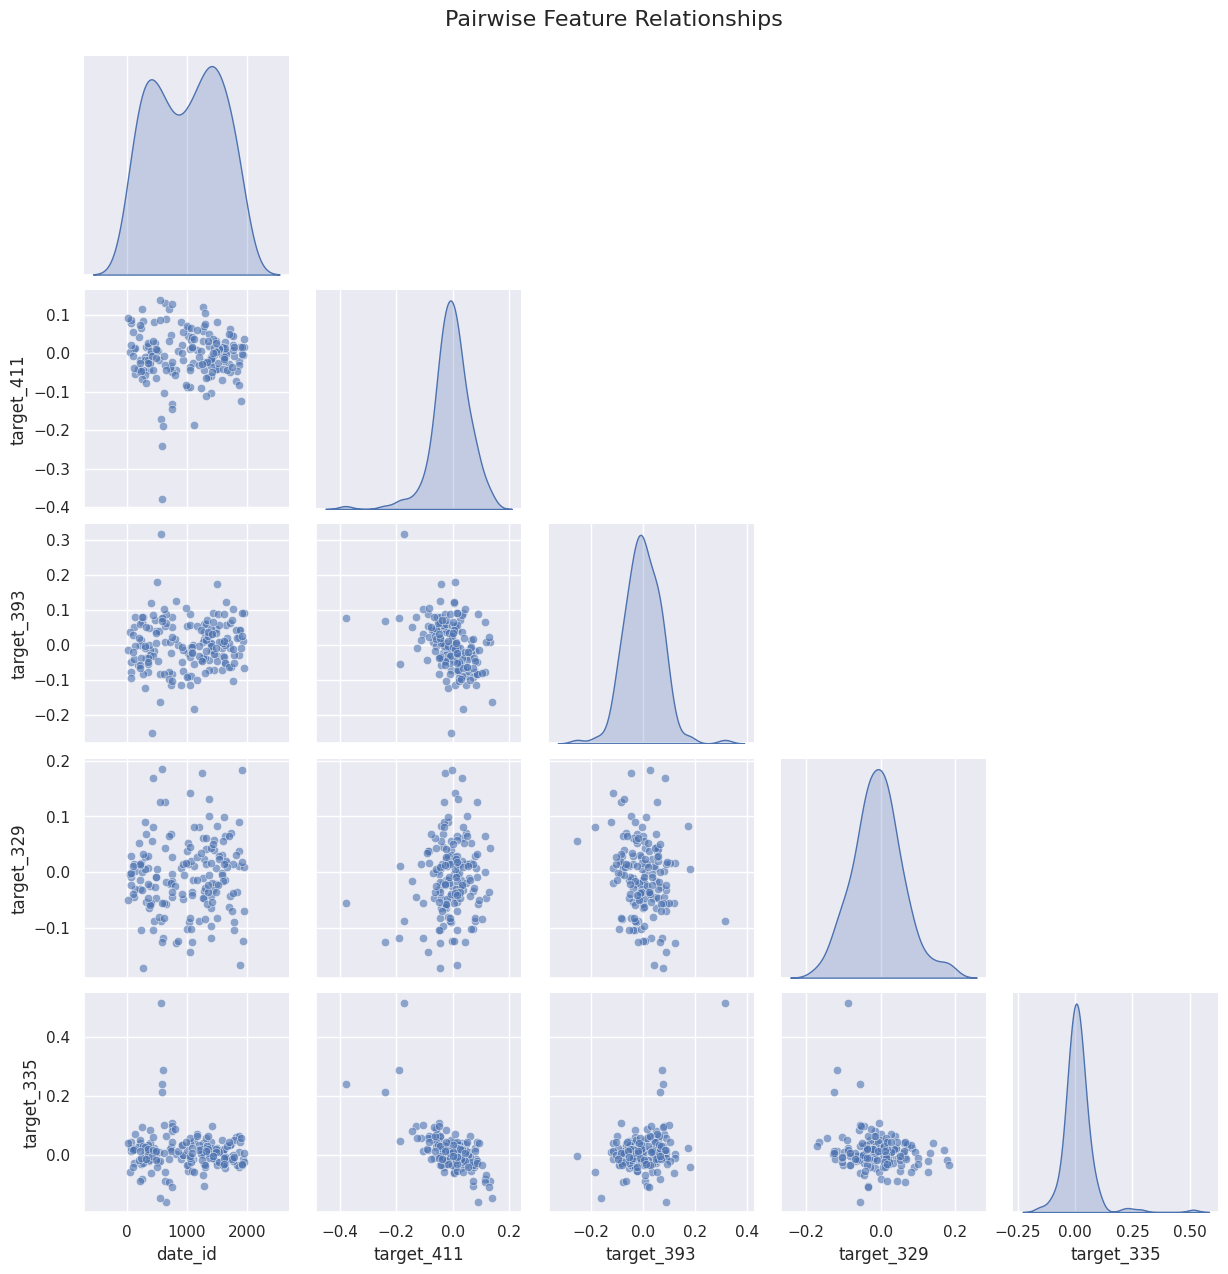

/usr/local/lib/python3.11/dist-packages/pandas/core/nanops.py:1025: RuntimeWarning: overflow encountered in cast
  result = result.astype(dtype, copy=False)



## Jointplot: JPX_Gold_Rolling-Spot_Futures_Close vs target_0
This jointplot compares the distribution of the highest-variance feature in the train set with the first target column. The regression line (if shown) and density estimates reveal the strength and form of the linear or nonlinear relationship.


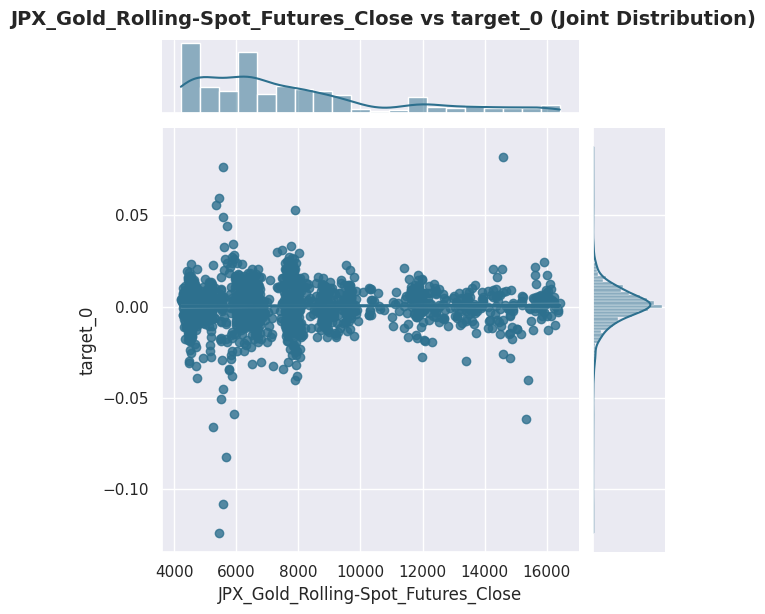

In [11]:
# ===================================================================================
#   Graphical EDA: Distribution, Missingness, and Pairwise Relationships (Clean Warnings)
# ===================================================================================
import matplotlib.gridspec as gridspec
import warnings

labels = reduce_mem_usage(pd.read_csv("/kaggle/input/mitsui-commodity-prediction-challenge/train_labels.csv"), verbose=True)

def upcast_for_plotting(df: pd.DataFrame) -> pd.DataFrame:
    df_plot = df.copy()
    for col in df_plot.select_dtypes(include=['float16']).columns:
        df_plot[col] = df_plot[col].astype(np.float32)
    return df_plot

def plot_missing_heatmap(df: pd.DataFrame, title: str, figsize=(18, 3)):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        plt.figure(figsize=figsize)
        sns.heatmap(df.isnull().astype(float), cbar=False, cmap="viridis", yticklabels=False)
        plt.title(f"Missing Values Heatmap – {title}", fontsize=15, fontweight="bold")
        plt.xlabel("Columns")
        plt.show()

def plot_feature_distributions(df: pd.DataFrame, columns: Optional[List[str]] = None, 
                              n: int = 12, bins: int = 60, title: Optional[str] = None):
    df_plot = upcast_for_plotting(df)
    if columns is None:
        columns = df_plot.select_dtypes(include=np.number).var().sort_values(ascending=False).index[:n].tolist()
    ncols = 4
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        for i, col in enumerate(columns):
            sns.histplot(df_plot[col].dropna(), bins=bins, kde=True, color=COLOR_PALETTE[i % len(COLOR_PALETTE)], ax=axes[i])
            axes[i].set_title(col, fontsize=11)
            axes[i].grid(alpha=0.3)
        for j in range(len(columns), len(axes)):
            axes[j].axis("off")
        if title:
            plt.suptitle(title, fontsize=16, fontweight="bold")
        plt.tight_layout(rect=[0, 0.03, 1, 0.97])
        plt.show()

def plot_target_distributions(df_labels: pd.DataFrame, n: int = 12):
    df_labels_plot = upcast_for_plotting(df_labels)
    target_cols = [col for col in df_labels_plot.columns if col.startswith("target_")][:n]
    plot_feature_distributions(df_labels_plot, columns=target_cols, n=n, title="Target Columns Distributions")

def plot_correlation_heatmap(df: pd.DataFrame, cols: Optional[List[str]] = None, title: Optional[str] = None):
    df_plot = upcast_for_plotting(df)
    if cols is None:
        cols = df_plot.select_dtypes(include=np.number).var().sort_values(ascending=False).index[:12].tolist()
    corr = df_plot[cols].corr()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, cbar_kws={"shrink": 0.7})
        plt.title(title or "Feature Correlation Heatmap", fontsize=15, fontweight="bold")
        plt.show()

def plot_pairplot(df: pd.DataFrame, cols: Optional[List[str]] = None, sample_n: int = 300):
    df_plot = upcast_for_plotting(df)
    if cols is None:
        cols = df_plot.select_dtypes(include=np.number).var().sort_values(ascending=False).index[:5].tolist()
    sample_df = df_plot[cols].sample(n=min(sample_n, len(df_plot)), random_state=42)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        sns.pairplot(sample_df, corner=True, diag_kind="kde", plot_kws={"alpha": 0.6})
        plt.suptitle("Pairwise Feature Relationships", y=1.02, fontsize=16)
        plt.show()

# --- a. Missingness patterns ---
print("## Missingness Heatmap\nThis plot shows where missing values appear in the columns for both the train and label sets. Bright yellow indicates missing (NaN), while dark blue indicates present values. Patterns of missingness can suggest issues with certain features or potential grouping by data provider or asset class.")
plot_missing_heatmap(train, "Train Set")
plot_missing_heatmap(labels, "Labels (Targets) Set")

# --- b. Feature distributions (top variance features) ---
print("\n## Feature Distributions\nBelow are histograms for the 12 features in the train set with the highest variance. Each plot reveals the range, skewness, modality, and outliers for individual features. This is crucial for identifying normalization needs or variable transformation opportunities.")
plot_feature_distributions(train, n=12, title="Top 12 Train Features by Variance")

# --- c. Target distributions ---
print("\n## Target Distributions\nThese histograms visualize the distributions of the first 12 target columns. Most targets represent price differences (returns) and may be centered around zero, but heavy tails or skewed distributions are common in financial time series.")
plot_target_distributions(labels, n=12)

# --- d. Correlation analysis among top train features ---
print("\n## Correlation Heatmap\nThis heatmap presents the pairwise Pearson correlation coefficients among the 12 most variable features. Strong blocks or off-diagonal colors may reveal clusters, redundancies, or highly informative combinations for modeling. Exxon is a large company in the financial sector and therefore XOM vs XLE is high. On the negative side you can see LQD and EEM as opposite plays. LQD is where you go when you're scared and look for safety (bonds), EEM is where you go when you want risk (Emerging Markets)")
plot_correlation_heatmap(train, title="Correlation Heatmap (Top 12 Train Features)")

# --- e. Pairwise feature scatterplot matrix ---
print("\n## Feature Pairplot\nThis grid of scatterplots (with histograms on the diagonal) explores joint distributions and relationships among a subset of train features. Look for linearity, heteroscedasticity, or clusters indicating feature interactions or anomalies.")
plot_pairplot(train)

# --- f. Pairwise target relationships (optional: smaller sample, heavy for big target sets) ---
print("\n## Target Pairplot\nAs above, but for the first few target columns. This visualizes the dependency structure among the targets, e.g., whether certain returns move together or display unique statistical regimes.")
plot_pairplot(labels, sample_n=200)

# --- g. (Bonus) Feature vs Target Jointplot Example ---
top_feat = train.select_dtypes(include=np.number).var().sort_values(ascending=False).index[0]
top_target = [col for col in labels.columns if col.startswith("target_")][0]
merged = train[[top_feat, "date_id"]].merge(labels[["date_id", top_target]], on="date_id", how="inner")
merged = upcast_for_plotting(merged)
print(f"\n## Jointplot: {top_feat} vs {top_target}\nThis jointplot compares the distribution of the highest-variance feature in the train set with the first target column. The regression line (if shown) and density estimates reveal the strength and form of the linear or nonlinear relationship.")
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    sns.jointplot(data=merged, x=top_feat, y=top_target, kind="reg", height=6, color=COLOR_PALETTE[3])
    plt.suptitle(f"{top_feat} vs {top_target} (Joint Distribution)", y=1.02, fontsize=14, fontweight="bold")
    plt.show()